In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

# Load the balanced data

balanced_data = pd.read_csv(r"C:\Users\turab\Diabetes_Classifier\csvs\balanced_data.csv")

# Separate features and target variable

X = balanced_data.drop(columns=['Diabetes_012'])
y = balanced_data['Diabetes_012']

# Split the data into training (80%) and test (20%) sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (512887, 18)
X_test shape: (128222, 18)
y_train shape: (512887,)
y_test shape: (128222,)


In [2]:
# Will need these later!

%store X_train
%store y_test
%store X_test
%store y_test
%store X
%store y

Stored 'X_train' (DataFrame)
Stored 'y_test' (Series)
Stored 'X_test' (DataFrame)
Stored 'y_test' (Series)
Stored 'X' (DataFrame)
Stored 'y' (Series)


Next, lets use 5 fold cross validation

In [3]:
# Cross-validation with 5 folds

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Display the indices for each fold

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}:")
    print(f"  Train: {len(train_index)}")
    print(f"  Validation: {len(val_index)}")


Fold 1:
  Train: 410309
  Validation: 102578
Fold 2:
  Train: 410309
  Validation: 102578
Fold 3:
  Train: 410310
  Validation: 102577
Fold 4:
  Train: 410310
  Validation: 102577
Fold 5:
  Train: 410310
  Validation: 102577


Now that that is done, its time to view the confusion matrix to see what errors are present

Confusion Matrix:
[[34703   299  7686]
 [ 3758 29107  9811]
 [ 5620 12174 25064]]


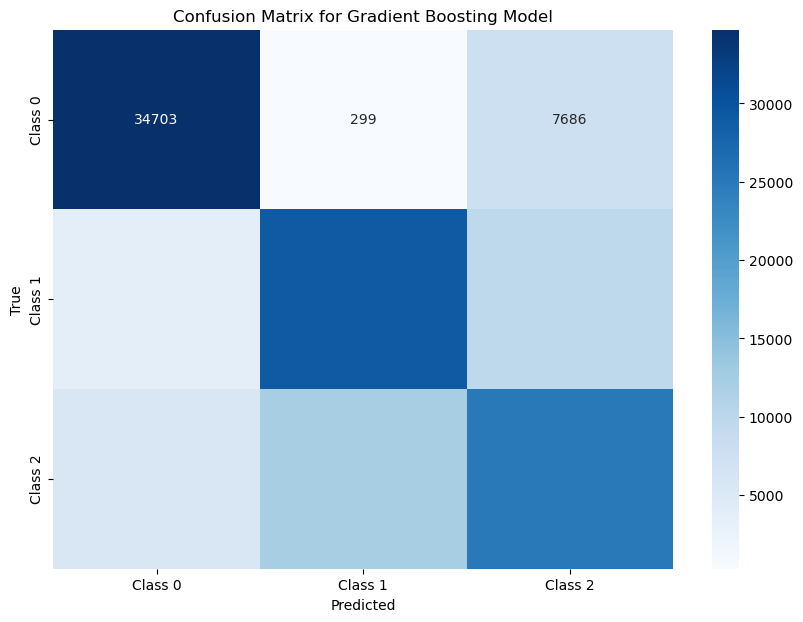

In [4]:
%store -r best_gb_model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set

y_pred_gb = best_gb_model.predict(X_test)

# Generate the confusion matrix

cm = confusion_matrix(y_test, y_pred_gb)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gradient Boosting Model')
plt.show()

CLASS 0: 


So, we have some false positives. 299 incorrectly predicted. 

We also have 7686 false negatives.


CLASS 1: 


False negatives, 9,811 instances of Class 1 incorrectly predicted.

False Positives, 3,758 instances of other classes incorrectly predicted as Class 1.


CLASS 2:

12174 for false negatives.

5620 false positives.

Ill view the classification report here and decide if i want to further improve my model

In [5]:
from sklearn.metrics import classification_report

# Print classification report

print("Classification Report:")
print(classification_report(y_test, y_pred_gb))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80     42688
         1.0       0.70      0.68      0.69     42676
         2.0       0.59      0.58      0.59     42858

    accuracy                           0.69    128222
   macro avg       0.69      0.69      0.69    128222
weighted avg       0.69      0.69      0.69    128222



Based on these, i have decided to improve the model, especially for class 2. Then evaluate preformance of test data again

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Define a smaller parameter grid for faster tuning

param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 6),
    'subsample': uniform(0.7, 0.3),
    'min_samples_split': randint(2, 10)
}

# Initialize RandomizedSearchCV

random_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Use a smaller subset of the data for faster tuning

X_train_subset = X_train.sample(frac=0.3, random_state=42)  # 30% of data
y_train_subset = y_train[X_train_subset.index]

# Fit RandomizedSearchCV

random_search.fit(X_train_subset, y_train_subset)

# Best parameters and score

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")

# Retrieve the best model

best_gb_model = random_search.best_estimator_

# Train the best model on the full training set

best_gb_model.fit(X_train, y_train)

# Predict and evaluate the model

y_pred_gb = best_gb_model.predict(X_test)
print("Best Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.08272719958564209, 'max_depth': 5, 'min_samples_split': 9, 'n_estimators': 127, 'subsample': 0.7587948587257435}
Best score: 0.7451
Best Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85     42688
         1.0       0.75      0.78      0.76     42676
         2.0       0.68      0.60      0.64     42858

    accuracy                           0.75    128222
   macro avg       0.75      0.75      0.75    128222
weighted avg       0.75      0.75      0.75    128222



Great, lets save this as the final refined version

In [7]:
import joblib

# Save the model

joblib.dump(best_gb_model, 'final_refined_gradient_boosting_model.pkl')

print("Model saved successfully as 'final_refined_boosting_model.pkl'")


Model saved successfully as 'best_gradient_boosting_model.pkl'
